# Simple LSTM for Sentiment Analysis (on IMDB reviews)
by Srinivas Prudhvi Somisetty(122021601001)

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [2]:
dataset, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteOL3BWA/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteOL3BWA/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteOL3BWA/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [3]:
for example, label in train_dataset.take(1):
  print("text: ", example.numpy())
  print("label: ", label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [5]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Wow...what can I say...First off IMDb says this is in the late 60s...which means Carlito would be very close to going to prison, He got out in 75 and said he was in for 5 years. They used a bunch of nobody actors, and a story that didn't even make sense. They bring back only one actor, Guzman, and hes playing a totally different guy. Why did it end with him and this Puerto Rican chick? Wheres Gale? He said he was in love with her before. Wheres Kleinfeld? He said he knew him forever...You'd think he'd have been in this one. And if this made sense, where are Rocco and the black dude in the first one? It was all just stupid...This is an insult to Pacino and the first film."
 b"For his first ever debut this film has some riveting and chilling moments. In the best horror film fashion the pit of your stomach tightens every moment during this film. The ending is superb. The makers of Blaire Witch obviously watched this film it's ending wasn't an end but a beginning of the end. A g

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label:text))

In [8]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [9]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 1, 69, 10, ...,  0,  0,  0],
       [16, 25, 86, ...,  0,  0,  0],
       [45, 23, 63, ...,  0,  0,  0]])

In [10]:
for n in range(3):
  print("original: ", example[n].numpy())
  print("round-trip: ", " ".join(vocab[encoded_example[n]]))

original:  b"Wow...what can I say...First off IMDb says this is in the late 60s...which means Carlito would be very close to going to prison, He got out in 75 and said he was in for 5 years. They used a bunch of nobody actors, and a story that didn't even make sense. They bring back only one actor, Guzman, and hes playing a totally different guy. Why did it end with him and this Puerto Rican chick? Wheres Gale? He said he was in love with her before. Wheres Kleinfeld? He said he knew him forever...You'd think he'd have been in this one. And if this made sense, where are Rocco and the black dude in the first one? It was all just stupid...This is an insult to Pacino and the first film."
round-trip:  [UNK] can i [UNK] off imdb says this is in the late [UNK] means [UNK] would be very close to going to [UNK] he got out in [UNK] and said he was in for 5 years they used a bunch of [UNK] actors and a story that didnt even make sense they bring back only one actor [UNK] and hes playing a totall

In [37]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [39]:
history =model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f0c3ef6c830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


391/391 [==============================] - 78s 48ms/step - loss: 0.6372 - accuracy: 0.5660 - val_loss: 0.5462 - val_accuracy: 0.6740
Epoch 2/5
391/391 [==============================] - 18s 45ms/step - loss: 0.4828 - accuracy: 0.7657 - val_loss: 0.4088 - val_accuracy: 0.8167
Epoch 3/5
391/391 [==============================] - 18s 46ms/step - loss: 0.3676 - accuracy: 0.8425 - val_loss: 0.3678 - val_accuracy: 0.8359
Epoch 4/5
391/391 [==============================] - 18s 46ms/step - loss: 0.3339 - accuracy: 0.8588 - val_loss: 0.3384 - val_accuracy: 0.8578
Epoch 5/5
391/391 [==============================] - 19s 46ms/step - loss: 0.3213 - accuracy: 0.8648 - val_loss: 0.3359 - val_accuracy: 0.8526


In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 101,249
Trainable params: 101,249
Non-trainable params: 0
_________________________________________________________________


In [41]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 10s 25ms/step - loss: 0.3272 - accuracy: 0.8542
Test Loss: 0.32721319794654846
Test Accuracy: 0.8541600108146667


In [42]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.6530341446399689)

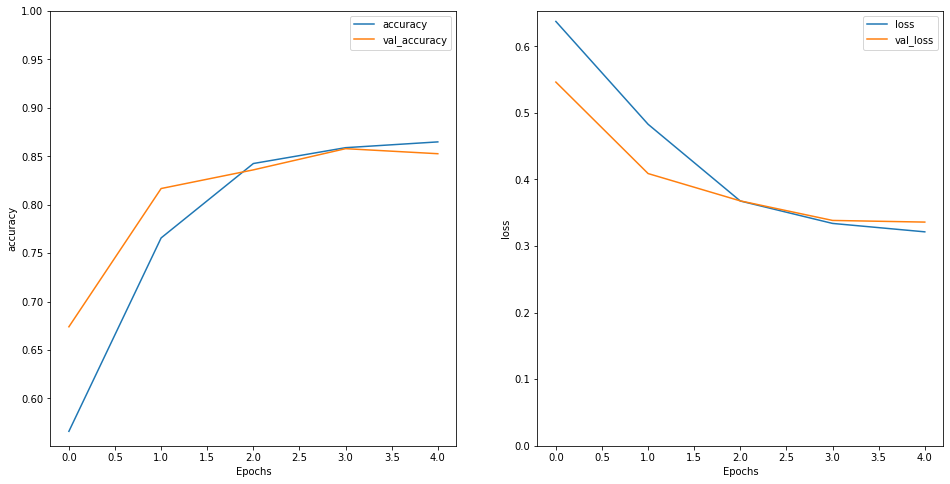

In [43]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [44]:
#@title Try the model for prediction(enter the review below to see the sentiment of the review)
review_text = "The movie was  good. The animation and the graphics" #@param {type:"string"}
#sample_text_1 = ('its not a good movie compared to previous one''would go for another watch')
predictions = model.predict(np.array([review_text]))
if predictions[0][0] > 0:
  print("The sentiment of the review is POSITIVE with polarity of : ",predictions[0][0])
else:
  print("The sentiment of the review is Negative with polarity of : ",predictions[0][0])

#print("The sentiment of the review is : ",predictions[0][0])



The sentiment of the review is POSITIVE with polarity of :  0.49449885
